In [1]:
import numpy as np
import ultraplot as uplt

## Notes on Neff from David


These values are for cosmocov from David and assume sigmae is 0.420 for all bins

```
And these are the values after weighting considering multiplicative shear bias values
- Initial neff = [2.55500673,2.25226626,2.36829023,1.69426732]
- m = [-0.00339767,0.0064552,0.01593935,0.00169811]
- neff * (1 + m)^2 = array([2.538, 2.281, 2.444, 1.7  ])
- sigmae = 0.420
```

The sigmae for cosmocov is `sqrt(2) * sigma_e` below.

The survey area comes from:

```
area_arcmin = 4031.036 * 60**2
```

and the raw per-component shape noise is

```
sigma_e = [0.26569122 0.2864663  0.28205497 0.34739085]
```

and the raw neff is

```
Number density for metadetection catalog for z-bin 0 [gal/arcmin^2]: 2.047
Number density for metadetection catalog for z-bin 1 [gal/arcmin^2]: 2.097
Number density for metadetection catalog for z-bin 2 [gal/arcmin^2]: 2.138
Number density for metadetection catalog for z-bin 3 [gal/arcmin^2]: 2.320
```

from this [notebook](https://github.com/des-science/DESY6Cats/blob/main/make_cats/LoadMastercat.ipynb)

From Judit the bin edges are

```
bin_edges = np.array([ 2.5       ,  3.14731353,  3.96223298,  4.98815579,  6.27971608,
        7.90569415,  9.95267926, 12.52968084, 15.77393361, 19.85820587,
       25.        , 31.47313529])
```
The data is in `.npy` files and has colunns

```
[theta, xip_var, xip_var_err, xim_var, xim_var_err, npairs, weight]
```

In [2]:
area_arcmin = 4031.036 * 60**2
sigma_e = np.array([0.26569122, 0.2864663, 0.28205497, 0.34739085])
bin_edges = np.array(
    [
        2.5       ,  3.14731353,  3.96223298,  4.98815579,  6.27971608,
        7.90569415,  9.95267926, 12.52968084, 15.77393361, 19.85820587,
        25.        , 31.47313529
    ]
)
neff = np.array([2.047, 2.097, 2.138, 2.320])
neff_cc = np.array([2.55500673, 2.25226626, 2.36829023, 1.69426732])
sigmae_cc = 0.420

In [3]:
tomo_ind = 0

dtype = [
    (nm.strip(), "f8")
    for nm in "theta, xip_var, xip_var_err, xim_var, xim_var_err, npairs, weight, xip_var_treecorr, xim_var_treecorr".split(",")
]
data = np.load(f"cs_variance_zbin{tomo_ind}.npy")
data = np.array([tuple(d) for d in data], dtype=dtype)

In [4]:
pred = []
pred_cc = []
for i in range(data.shape[0]):
    bin_area = np.pi * (bin_edges[i+1]**2 - bin_edges[i]**2)
    npgeom = neff[tomo_ind]**2 * area_arcmin * bin_area
    var = 4 * sigma_e[tomo_ind]**4 / npgeom
    pred.append(var)
    npgeom_cc = neff_cc[tomo_ind]**2 * area_arcmin * bin_area
    var_cc = sigmae_cc**4 / npgeom_cc
    pred_cc.append(var_cc)

pred = np.array(pred)
pred_cc = np.array(pred_cc)

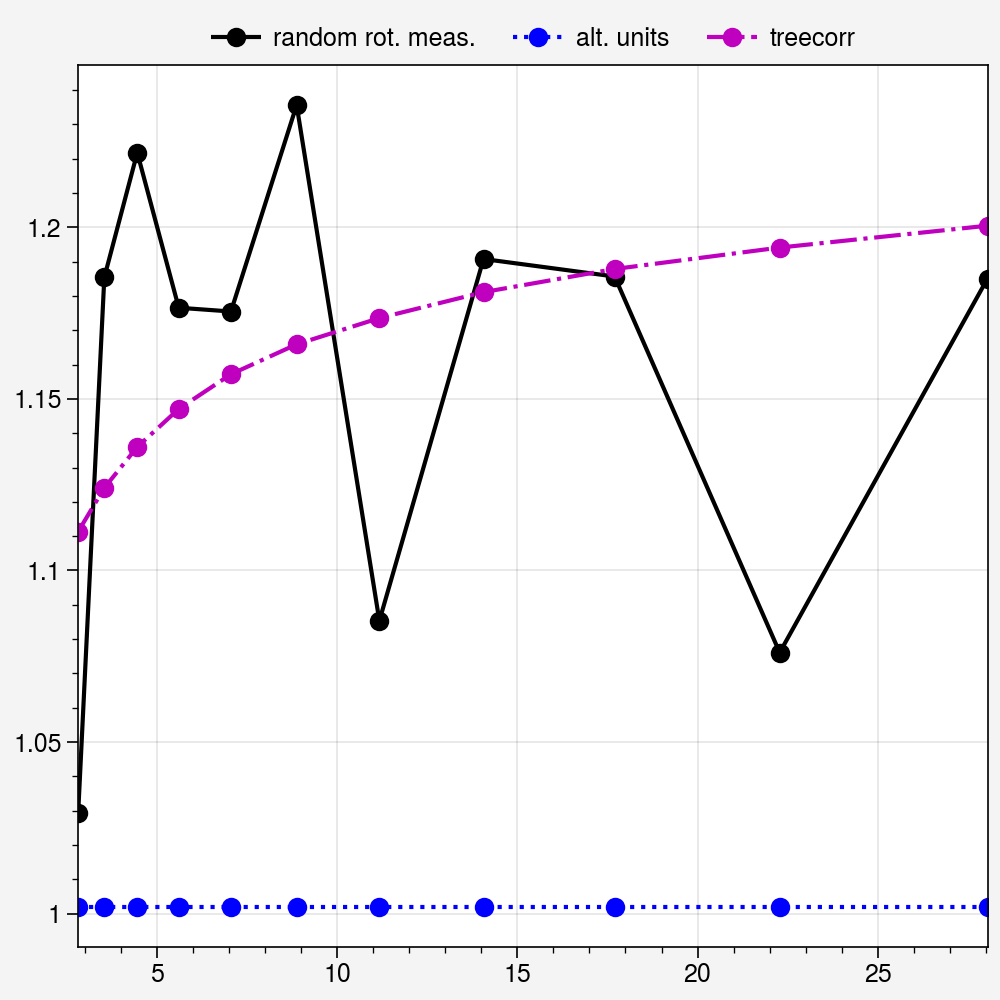

In [5]:
fig, axs = uplt.subplots(figsize=(5, 5))

est = 0.5 * (data["xip_var"] + data["xim_var"])
tcest = 0.5 * (data["xip_var_treecorr"] + data["xim_var_treecorr"])

axs.plot(data["theta"], est / pred, "o-k", label="random rot. meas.")
axs.plot(data["theta"], pred_cc / pred, "o:b", label="alt. units")
axs.plot(data["theta"], tcest / pred, "o-.m", label="treecorr")

axs.legend(loc="t", frameon=False)

Now try to use treecorr to compute the pair estimator quantities directly.

We need for each bin

$$
\sigma_{e}^4\frac{\sum_{{\rm pairs\ }ij} (w_i w_j)^2}{(\sum_{{\rm pairs\ }ij}w_i w_j)^2}
$$

In [6]:
def _read_treecorr(fname, n_bins):
    data = []
    for bin_ind in range(n_bins):
        _fname = fname + f"_ab{bin_ind}.txt"
        with open(_fname, "r") as fp:
            for line in fp:
                if line.startswith("#") and "{" not in line:
                    names = line.replace("#", "").split()
                    break

        dtype = [(nm, "f8") for nm in names]
        _d = np.array([np.loadtxt(_fname, dtype=dtype)], dtype=dtype)
        if bin_ind == 0:
            global_dtype = dtype
        else:
            assert global_dtype == dtype
        data.append(_d[0])
    return np.array(data, dtype=dtype)

fname = f"wsum_b{tomo_ind}_cross"
dwc = _read_treecorr(fname, len(bin_edges)-1)
fname = f"w2sum_b{tomo_ind}_cross"
dw2c = _read_treecorr(fname, len(bin_edges)-1)

In [7]:
var_pair = 4 * sigma_e[tomo_ind]**4  * dw2c["weight"] / dwc["weight"]**2

In [8]:
def _read_cosmocov_for_tomoind(tomo_ind):
    if tomo_ind == 0:
        ind_start = 0
    elif tomo_ind == 1:
        ind_start = 44
    elif tomo_ind == 2:
        ind_start = 77
    else:
        ind_start = 99

    vals = np.loadtxt("cosmocov_sn.txt")
    return vals[ind_start:ind_start + 11]

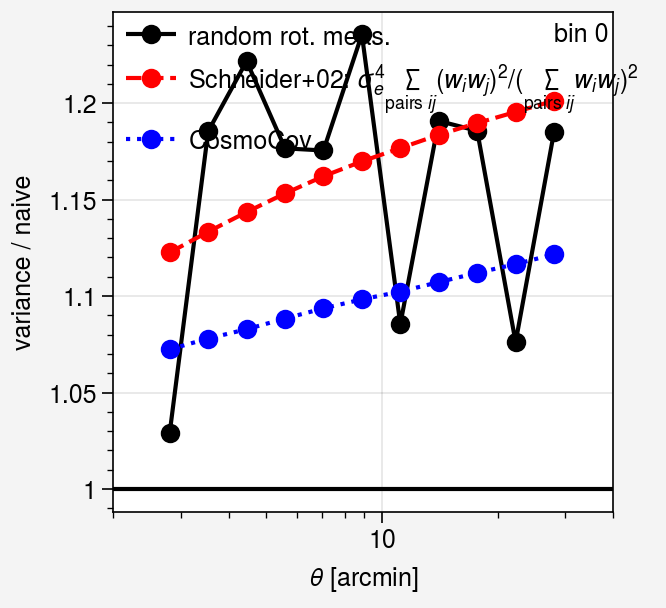

In [9]:
fig, axs = uplt.subplots()

est = 0.5 * (data["xip_var"] + data["xim_var"])
cc = _read_cosmocov_for_tomoind(tomo_ind)**2

axs.plot(
    data["theta"],
    est / pred,
    "o-k",
    label=r"random rot. meas."
)

axs.plot(
    data["theta"],
    var_pair / pred,
    "o--r",
    label=r"Schneider+02: $\sigma_{e}^4\sum_{{\rm pairs\ }ij} (w_i w_j)^2/(\sum_{{\rm pairs\ }ij}w_i w_j)^2$"
)

axs.plot(
    data["theta"],
    cc / pred,
    "o:b",
    label=r"CosmoCov"
)

axs.axhline(1, color="k")
axs.legend(loc="ul", frameon=False, ncols=1)
axs.text(0.99, 0.98, f"bin {tomo_ind}", ha="right", va="top", transform=axs[0, 0].transAxes)
axs.format(
    xlabel=r"$\theta$ [arcmin]",
    ylabel="variance / naive",
    # ylim=(0.8, 1.7),
    xlim=(2, 40),
    xscale="log"
)

## Plot it all

tomo ind: 0
theta: [ 2.80504614  3.53134386  4.44569853  5.59680285  7.04595733  8.87033473
 11.1670898  14.05853313 17.69864461 22.28127345 28.05046136]
npairs: [4.00766598e+08 6.29062316e+08 9.88028336e+08 1.55266187e+09
 2.44169682e+09 3.84402721e+09 6.05649418e+09 9.54273777e+09
 1.50450421e+10 2.37299933e+10 3.74234937e+10]
tomo ind: 1
theta: [ 2.80504614  3.53134386  4.44569853  5.59680285  7.04595733  8.87033473
 11.1670898  14.05853313 17.69864461 22.28127345 28.05046136]
npairs: [4.25743924e+08 6.67138523e+08 1.04675838e+09 1.64376917e+09
 2.58302638e+09 4.06472532e+09 6.40157192e+09 1.00797784e+10
 1.58838637e+10 2.50449143e+10 3.94827695e+10]
tomo ind: 2
theta: [ 2.80504614  3.53134386  4.44569853  5.59680285  7.04595733  8.87033473
 11.1670898  14.05853313 17.69864461 22.28127345 28.05046136]
npairs: [4.26594101e+08 6.69602434e+08 1.05207411e+09 1.65402568e+09
 2.60085653e+09 4.09488283e+09 6.45245584e+09 1.01627170e+10
 1.60186844e+10 2.52654144e+10 3.98445710e+10]
tomo in

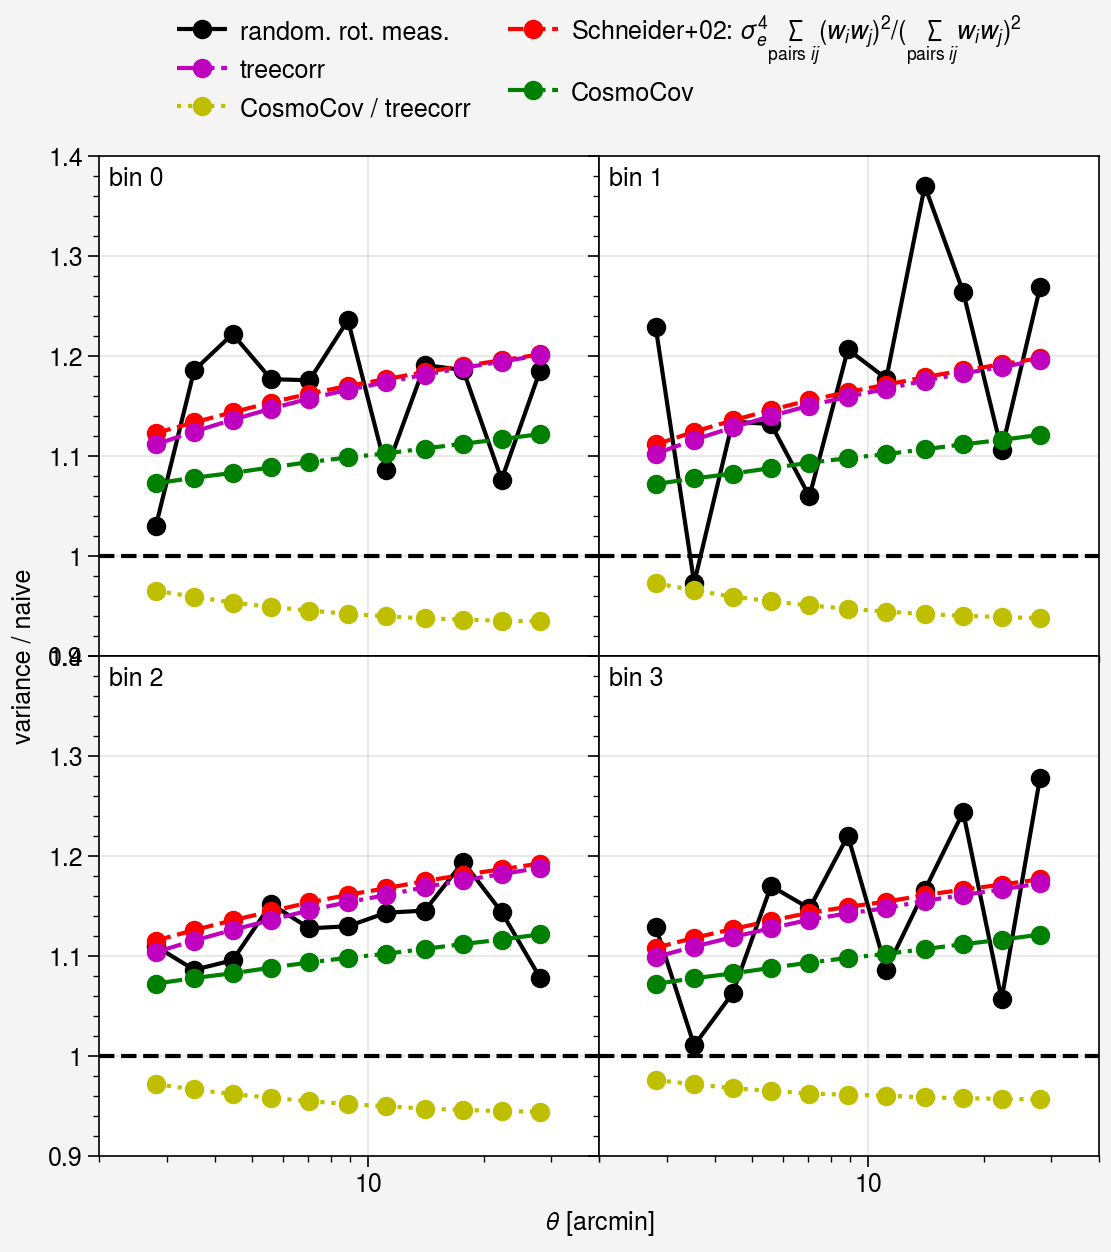

In [11]:
def _plot_tomo_ind(ax, tomo_ind):
    dtype = [
        (nm.strip(), "f8")
        for nm in "theta, xip_var, xip_var_err, xim_var, xim_var_err, npairs, weight, xip_var_treecorr, xim_var_treecorr".split(",")
    ]
    data = np.load(f"cs_variance_zbin{tomo_ind}.npy")
    data = np.array([tuple(d) for d in data], dtype=dtype)
    print("tomo ind:", tomo_ind)
    print("theta:", data["theta"])
    print("npairs:", data["npairs"])

    pred = []
    pred_cc = []
    for i in range(data.shape[0]):
        bin_area = np.pi * (bin_edges[i+1]**2 - bin_edges[i]**2)
        npgeom = neff[tomo_ind]**2 * area_arcmin * bin_area
        var = 4 * sigma_e[tomo_ind]**4 / npgeom
        pred.append(var)
        npgeom_cc = neff_cc[tomo_ind]**2 * area_arcmin * bin_area
        var_cc = sigmae_cc**4 / npgeom_cc
        pred_cc.append(var_cc)

    pred = np.array(pred)
    pred_cc = np.array(pred_cc)

    fname = f"wsum_b{tomo_ind}_cross"
    dwc = _read_treecorr(fname, len(bin_edges)-1)
    fname = f"w2sum_b{tomo_ind}_cross"
    dw2c = _read_treecorr(fname, len(bin_edges)-1)

    var_pair = 4 * sigma_e[tomo_ind]**4  * dw2c["weight"] / dwc["weight"]**2

    est = 0.5 * (data["xip_var"] + data["xim_var"])
    tcest = 0.5 * (data["xip_var_treecorr"] + data["xim_var_treecorr"])
    cc = _read_cosmocov_for_tomoind(tomo_ind)**2

    ax.plot(
        data["theta"],
        est / pred,
        "o-k",
        label=(
            r"random. rot. meas."
            if tomo_ind == 0 else None
        ),
    )
    ax.plot(
        data["theta"],
        var_pair / pred,
        "o--r",
        label=(
            r"Schneider+02: $\sigma_{e}^4\sum_{{\rm pairs\ }ij} (w_i w_j)^2/(\sum_{{\rm pairs\ }ij}w_i w_j)^2$"
            if tomo_ind == 0 else None
        )
    )
    ax.plot(
        data["theta"],
        tcest / pred,
        "o-.m",
        label="treecorr" if tomo_ind == 0 else None
    )

    ax.plot(
        data["theta"],
        cc / pred ,
        "o-.g",
        label=r"CosmoCov" if tomo_ind == 0 else None
    )

    ax.plot(
        data["theta"],
        cc / tcest ,
        "o:y",
        label=r"CosmoCov / treecorr" if tomo_ind == 0 else None
    )


    ax.axhline(1, color="k", linestyle="dashed")

    ax.text(0.02, 0.98, f"bin {tomo_ind}", ha="left", va="top", transform=ax.transAxes)
    ax.format(
        xlabel=r"$\theta$ [arcmin]",
        ylabel="variance / naive",
        xscale="log",
        xlim=(2, 40),
        ylim=(0.9, 1.4),
    )


fig, axs = uplt.subplots(nrows=2, ncols=2, share=4, wspace=0, hspace=0)

tomo_ind = -1
for row in range(2):
    for col in range(2):
        ax = axs[row, col]
        tomo_ind += 1
        _plot_tomo_ind(ax, tomo_ind)

fig.legend(loc="t", frameon=False, ncols=2)
